# Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

import qda

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller, kpss

def check_gaussianity(data_points, title="",plotto=1):
	if str(type(data_points)) == "<class 'pandas.core.series.Series'>":
		data_points = data_points.dropna().values
	if plotto==1:
		plt.figure(figsize=(12,4))
		plt.subplot(1, 3, 1)
		stats.probplot(data_points,plot=plt)
		plt.subplot(1, 3, 2)
		# plt.hist(data_points)
		sns.histplot(data_points, kde=True, stat="density", linewidth=0)
		plt.subplot(1, 3, 3)
		plt.plot(data_points,'o-')
		plt.suptitle(f"{title}")
		plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({title}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	print('H0 is "data are gaussian" => conclusion is good if pvalue is high')

def check_randomness(data_points, title="", plotto=1, layout="h"):
	if plotto==1:
		if layout=="v":
			fig, ax = plt.subplots(3,1, figsize=(8,12))
		else:
			fig, ax = plt.subplots(1,3, figsize=(12,4))
		sgt.plot_acf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[0])
		fig.subplots_adjust(hspace=0.3)
		sgt.plot_pacf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[1], method = 'ywm')
		ax[2].plot(data_points,'o-')
		plt.show()	
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({title}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')
	print('H0 is "data are random" => conclusion is good if pvalue is high')
	#
	# and stationarity
	#
	# Perform ADF test
	adf_result = adfuller(data_points)
	adf_pvalue = adf_result[1]
	print(f"({title}) ADF test p-value = {adf_pvalue} - Stationarity at alpha 5%? {adf_pvalue <= 0.05}")
	print('H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low')

def check_assumptions(data_points, title="",plotto=1):
	check_gaussianity(data_points, title,plotto)
	check_randomness(data_points, title,plotto)

def check_residuals(model):
	fig, axs = plt.subplots(2, 2, figsize=(12, 7))
	fig.suptitle('Residual Plots')
	stats.probplot(model.resid, dist="norm", plot=axs[0, 0])
	axs[0, 0].set_title('Normal Probability Plot')
	axs[0, 1].scatter(model.fittedvalues, model.resid)
	axs[0, 1].set_xlabel('Fitted Values')
	axs[0, 1].set_ylabel('Residuals')
	axs[0, 1].set_title('Residuals vs Fitted Values')
	plt.subplot(2, 2, 3)
	sns.histplot(model.resid, kde=True, stat="density", linewidth=0)
	plt.title('Histogram with KDE')
	axs[1, 1].plot(np.arange(1, len(model.resid) + 1), model.resid, 'o-')
	axs[1, 1].set_title('Residuals Over Time')
	_, pval_SW_res = stats.shapiro(model.resid)
	plt.tight_layout()
	plt.subplots_adjust(top=0.88, hspace=0.3) 
	check_randomness(model.resid, title="Residuals")
	check_gaussianity(model.resid, title="Residuals", plotto=0)

def get_ooc(df):
    # Filter columns that contain the word "TEST"
    test_columns = [col for col in df.columns if "TEST" in col]
    # Initialize a dictionary to store the indices and their corresponding columns with NaNs
    nan_info = {}
    # Iterate over the test columns to find NaN values
    for col in test_columns:
        nan_indices = df[col].index[df[col].notnull()].tolist()
        for idx in nan_indices:
            if idx in nan_info:
                nan_info[idx].append(col)
            else:
                nan_info[idx] = [col]
    # Print the results
    for idx, cols in nan_info.items():
        print(f'Index {idx} (ie sample {idx+1}) is ooc from column {cols}')

# Function for batching
def batch_data(data, k):
    data_batched = []
    for i in range(0, len(data), k):
        if i + k <= len(data):
            batch = data[i:i + k]
            avg = batch.mean()
            data_batched.append(avg)
    return pd.DataFrame(data_batched, columns=['x'])

# Function for gapping
def gap_data(data, k):
    data_gapped = data[::k]
    return pd.DataFrame(data_gapped, columns=['x'])

# Ex1
time start: .41  
The concentration of a contaminant (measured in ppm) in the production of synthetic rubber is monitored over
time. ‘230609_ex1.csv’ contains the measurements collected in 50 consecutive samples.

In [2]:
data = pd.read_csv("../Exams/simulation/2024 exam simulation/240606_ex1.csv")
COLNAME = 'Concentration'
data.head()

,Sample,Concentration
0,1,8.36
1,2,12.72
2,3,8.60
3,4,7.72
4,5,5.97


## A
Being known that a negative value is the result of a temporary miscalibration of the measuring device, fit
a suitable model to these data;

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


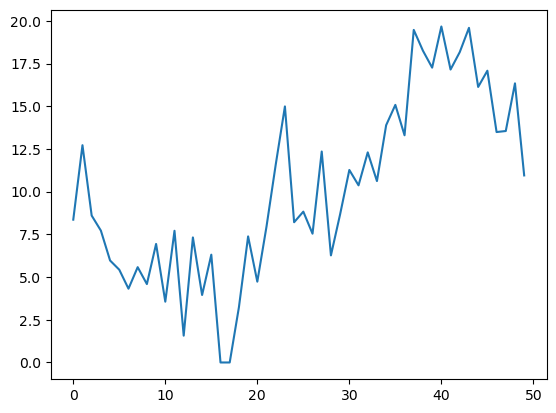

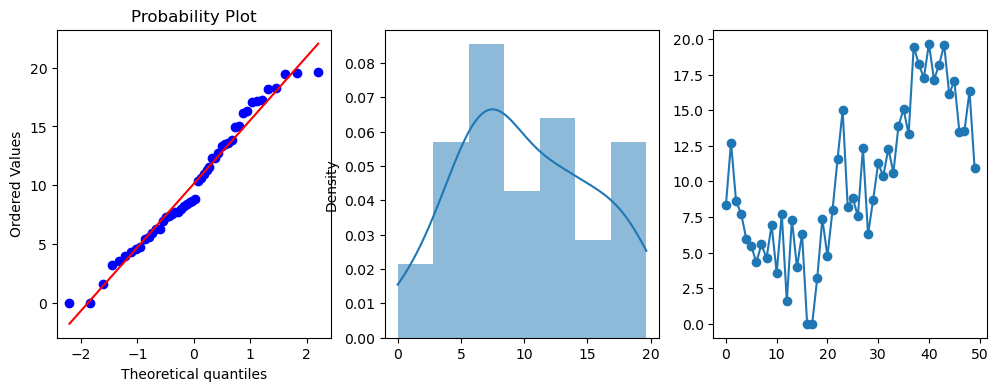

() Normality p-value = 0.1948554813861847 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


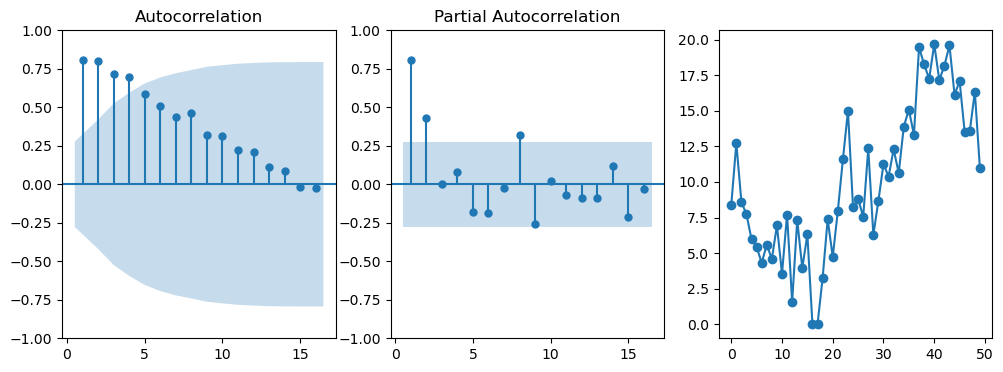

() Runs test p-value = 2.7343384749349e-07 - Random data at alpha 5%? False
H0 is "data are random" => conclusion is good if pvalue is high
() ADF test p-value = 0.6684156617868071 - Stationarity at alpha 5%? False
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low


In [42]:
plt.plot(data[COLNAME])
# fix negative errors?
data[COLNAME][np.where(data[COLNAME]<=0)[0]] = 0
check_assumptions(data[COLNAME])

In [83]:
def is_corr_lagk_significant(k,data,COLNAME):
	# calculate the lag k from data
	data['lagk'] = data[COLNAME].shift(k)
	# calculate the difference between the data and the lagk
	data['diffk'] = data[COLNAME] - data['lagk']

	n = len(data['diffk'][k:])
	#autocorrelation function
	[acf_values, lbq, _] = acf(data['diffk'][k:], nlags = int(np.sqrt(n)), qstat=True, fft = False)
	# Bartlett's test at lag k
	# to check if lag k correlation is significant
	alpha = 0.05
	lag_test = k
	rk = acf_values[lag_test]
	z_alpha2 = stats.norm.ppf(1-alpha/2)
	print('Test statistic rk = %f' % rk)
	print('Rejection region is at +-%f' % (z_alpha2/np.sqrt(n)))

In [82]:
is_corr_lagk_significant(2,data,COLNAME)

Test statistic rk = -0.209587
Rejection region is at +-0.282896


                               SARIMAX Results                                
Dep. Variable:          Concentration   No. Observations:                   50
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -122.790
Date:                Sat, 15 Jun 2024   AIC                            253.579
Time:                        15:39:51   BIC                            261.227
Sample:                             0   HQIC                           256.492
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4902      3.223      3.255      0.001       4.174      16.807
ar.L1          0.4172      0.131      3.187      0.001       0.161       0.674
ar.L2          0.4590      0.128      3.573      0.0

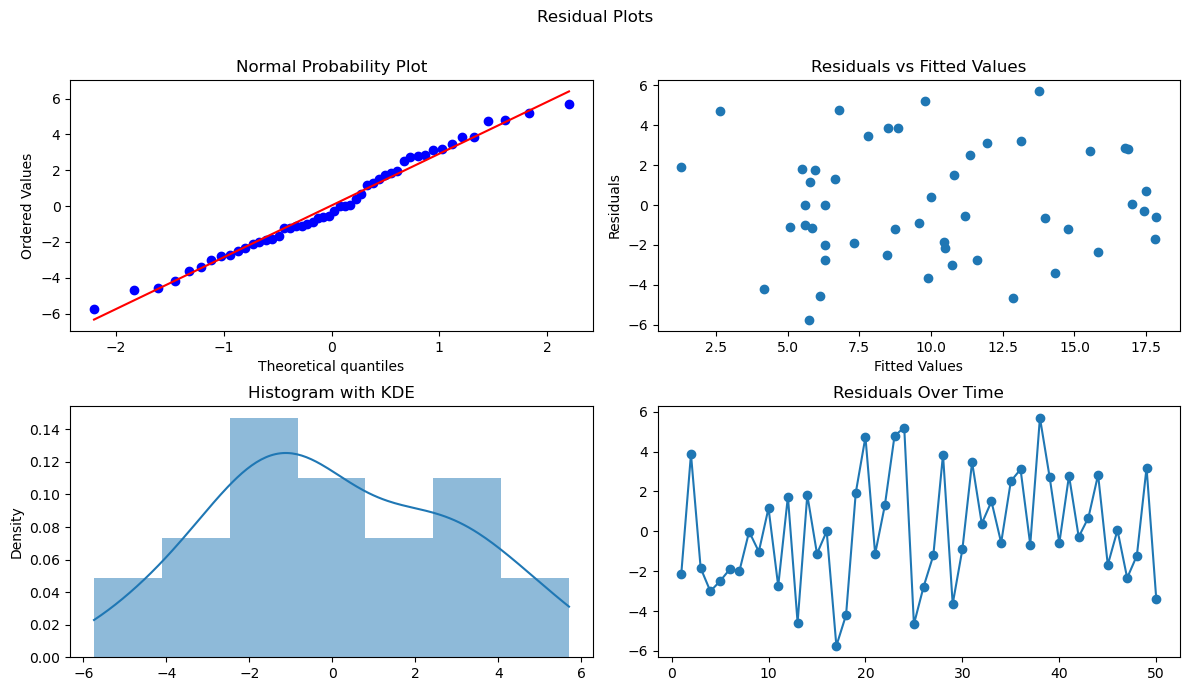

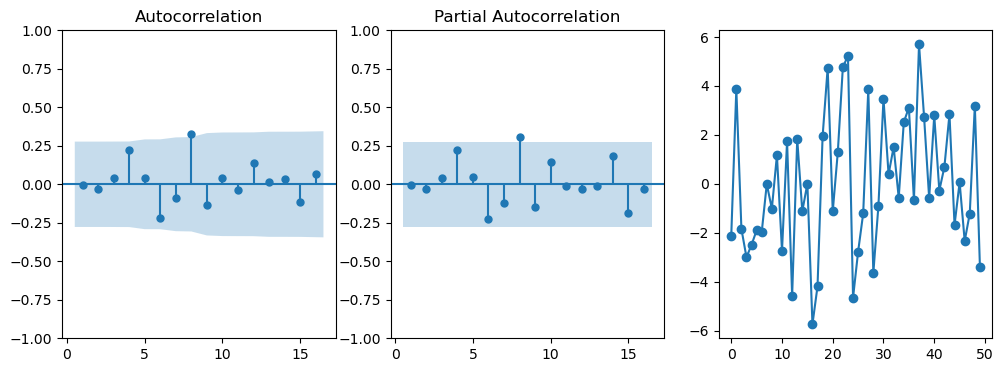

(Residuals) Runs test p-value = 0.32979565973267366 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
(Residuals) ADF test p-value = 2.1684586339677613e-09 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low
(Residuals) Normality p-value = 0.5561623573303223 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [136]:
# acf geom decay, pacf relevant at 1 or 2 => ar(1 or 2) maybe
# from the above test corr 2 seems not significant
# but from the pvalue of the model on ar2 coeff it seems significant
# Fit an ARIMA model
orders = (2, # AR(p)
		  0, # I(d)
		  0) # MA(q)from statsmodels.tsa.arima.model import ARIMA
arma_model = tsa.ARIMA(data[COLNAME], order=orders)
# use this if you dont want the constant termn (eg if it is not significant)
# arma_model = tsa.ARIMA(data['temp'], order=orders, trend='n') 
arma_model = arma_model.fit()

# Print model summary
print(arma_model.summary())
# Get the residuals
residuals = arma_model.resid
check_residuals(arma_model)

# so we settle on AR(2)

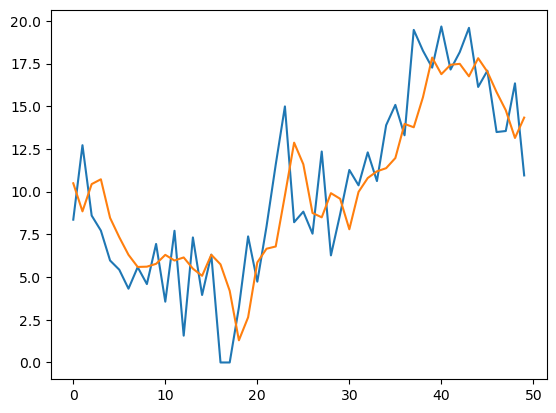

In [106]:
plt.plot(data[COLNAME])
plt.plot(arma_model.fittedvalues)

## B
Based on the result of point a), estimate the 95% prediction interval for the contaminant concentration in
the next sample.

(50, 4)
13.36708676 2.7817620315188716
CI = (7.915, 18.819)
50    13.367387
dtype: float64
>>> forecast summary:
 Concentration       mean   mean_se  mean_ci_lower  mean_ci_upper
50             13.367387  2.781753        7.91525      18.819523 



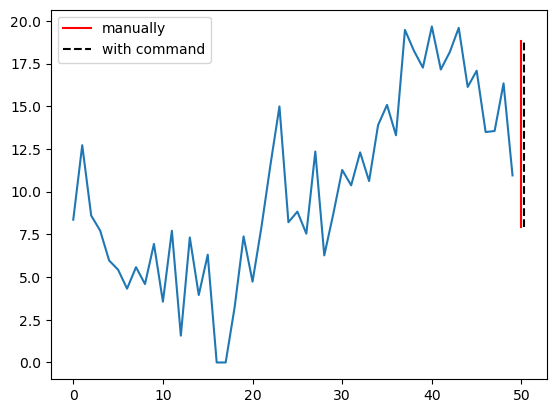

In [131]:
# model gave these params/coeffs
const      =   10.4902   
arL1       =   0.4172   
arL2       =   0.4590   
sigma2     =    7.7382
# so Yt = const + arl1*yt-1 + arl2*yt-2 +eps, with eps distr as N(0,sigma2)
# so we can try
print(data.shape)
mu_ = const + arL1*(data[COLNAME][49]-const) + arL2*(data[COLNAME][48]-const) # not sure what im doing
sigma_ = np.sqrt(sigma2)
print(mu_,sigma_)

alpha = 0.05
# Estimate confidence interval (control limits) 
CI = stats.norm.interval(1-alpha, loc=mu_, scale=sigma_)
print('CI = (%.3f, %.3f)' % CI)

# Forecast pointwise
print(arma_model.forecast(steps=1, alpha=0.05))
# Forecast interval
fcast_res = arma_model.get_forecast()
print(">>> forecast summary:\n", fcast_res.summary_frame(alpha=0.05), "\n")

plt.plot(data[COLNAME])
plt.plot([50,50], [7.915,18.819],"r",label="manually")
plt.plot([50.3,50.3], [7.91525,18.819523],"k--",label="with command")
plt.legend()

## C
Based on the result of point a), design an appropriate control chart for these data with ARL 0 = 250.

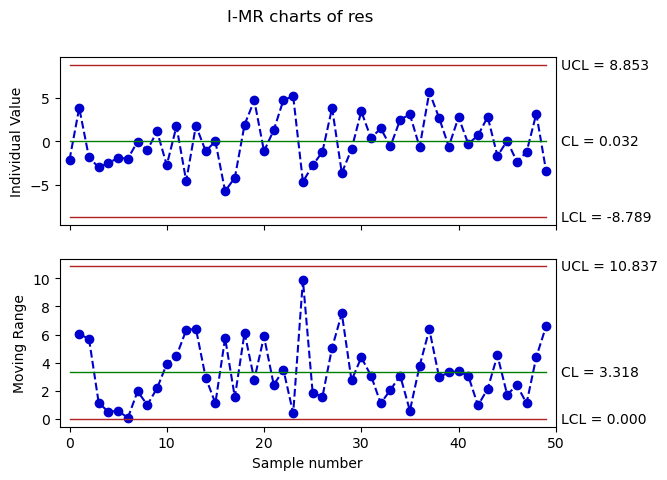

In [132]:
# ARL0 = 1/(1-beta) in control = 1/alpha
alpha = 1/250
# we build the chart on the residuals
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(arma_model.resid, columns=['res'])
# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

## D
From historical data, it is known that the most appropriate model for this process yielded a standard
deviation of residuals equal to σ ε = 2.5. Determine, with a statistical test, if the model fitted at point a) is
such that the standard deviation of residuals is greater than this value (report also the p-value of the test).
Discuss the result.

In [140]:
print(arma_model.resid.var())
print("7.7382") # from sigma2 in the summary of the model

8.022607737603053
7.7382


In [144]:
#  One-sided CI on the variance
# H0:sigmares<sigma0      vs     H1: sigmares>sigma0
alpha=0.05
df = 50 - 2      # Degrees of freedom
chi_alpha = stats.chi2.ppf(1-alpha, df)

chi0 = df * arma_model.resid.var() / (2.5**2)
if chi0 > chi_alpha:
    print('Reject the null hypothesis at alpha = %.2f' % alpha)
else:
    print('Accept the null hypothesis at alpha = %.2f' % alpha)
pval = 1 - stats.chi2.cdf(chi0, df)
print('p-value = %.3f' % pval)

chi0 = df * 7.7382 / (2.5**2)
if chi0 > chi_alpha:
    print('Reject the null hypothesis at alpha = %.2f' % alpha)
else:
    print('Accept the null hypothesis at alpha = %.2f' % alpha)
pval = 1 - stats.chi2.cdf(chi0, df)
print('p-value = %.3f' % pval)
# in both cases i accept H0

Accept the null hypothesis at alpha = 0.05
p-value = 0.090
Accept the null hypothesis at alpha = 0.05
p-value = 0.125


## E

# Ex2

## A

## B

## C

## D

## E